In [ ]:
import numpy as np
from scipy.io import mmread
# from scipy.sparse import csr_matrix # Non usata se A è densa
import time
from scipy.optimize import minimize_scalar
import pandas as pd
import matplotlib as plt

def projection_simplex(v, z=1.0):
    """Project vector v onto the simplex (sum(x)=z, x>=0)."""
    n = len(v)
    if n == 0: return np.array([])
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    
    # Trova rho: l'indice più grande tale che u[rho-1] - (cssv[rho-1] - z) / rho > 0
    # (Usando indicizzazione 0-based per rho_idx, quindi rho = rho_idx + 1)
    rho_idx = -1
    for i in range(n - 1, -1, -1): # Itera da n-1 giù fino a 0
        if u[i] + (z - cssv[i]) / (i + 1) > 0: # cssv[i] è sum_{j=0 to i} u[j]
            rho_idx = i
            break
    
    # Se nessun rho trovato (es. tutti gli u_i sono molto negativi e z piccolo),
    # rho_idx rimane -1. Questo non dovrebbe accadere per z > 0 e input ragionevoli.
    # In Duchi et al. 2008, si dimostra che rho >= 1.
    if rho_idx == -1: # Fallback nel caso improbabile (es. z=0, tutti v<=0)
        if z == 0: return np.zeros(n)
        # Se z > 0, la teoria dice che rho >= 1 (cioè rho_idx >= 0)
        # Questo fallback è per estrema robustezza o casi degeneri.
        # Se tutti v_i sono <=0 e z>0, un vertice dovrebbe prendere tutto il peso.
        # Per semplicità, se non troviamo rho, e z > 0, è una situazione anomala.
        # L'implementazione originale con `ind[cond][-1]` era più concisa.
        # Per ora, assumiamo che rho_idx venga trovato se z > 0.
        # Se z>0 e non si trova rho, significa che tutti u_i + (z - cssv_i)/(i+1) <=0
        # Considera un caso semplice: v = [-1, -2], z = 1. u = [-1, -2]. cssv = [-1, -3].
        # i=1 (rho_idx=1): u[1] + (1 - cssv[1]) / 2 = -2 + (1 - (-3)) / 2 = -2 + 4/2 = 0. Non > 0.
        # i=0 (rho_idx=0): u[0] + (1 - cssv[0]) / 1 = -1 + (1 - (-1)) / 1 = -1 + 2 = 1. > 0. rho_idx = 0.
        # Quindi rho = 1.
        # Se z > 0, rho_idx sarà almeno 0.
        pass # rho_idx dovrebbe essere >=0

    # theta = (sum_{i=0 to rho_idx} u[i] - z) / (rho_idx + 1)
    theta = (cssv[rho_idx] - z) / (rho_idx + 1.0)
    
    proj_v = np.maximum(v - theta, 0)
    
    # Opzionale: normalizzazione finale per assicurare sum(x)=z a causa di errori numerici
    current_sum = np.sum(proj_v)
    if z > 1e-9: # Evita divisione per zero se z è ~0
        if abs(current_sum - z) > 1e-7 * z: # Controlla differenza relativa
            if current_sum > 1e-9: # Evita divisione per zero se current_sum è ~0
                proj_v = proj_v * (z / current_sum)
            else: # Se la somma è zero ma dovrebbe essere positiva, distribuisci z
                  # Questo indica un problema o un caso degenere.
                  # Ad es. assegna a un elemento o uniformemente (violerebbe sparsità)
                  # Per ora, ci fidiamo dell'algoritmo sopra, ma questo è un fallback.
                  # print(f"Avviso: somma proiezione simplesso {current_sum} diversa da target {z}.")
                  pass
    elif abs(current_sum) > 1e-7 : # se z=0, current_sum dovrebbe essere 0
         proj_v = np.zeros(n)
         
    return proj_v


def lmo(grad):
    """Linear Minimization Oracle for the simplex."""
    i = np.argmin(grad)
    s = np.zeros_like(grad)
    s[i] = 1.0
    return s, i # Restituisce anche l'indice per comodità

def f_l2(x, A):
    """L2-regularized objective function (da MASSIMIZZARE)."""
    return x @ A @ x + 0.5 * np.dot(x, x)

def grad_l2(x, A):
    """Gradient for L2-regularized objective (per MASSIMIZZAZIONE)."""
    # Il gradiente di x^T A x è (A+A^T)x. Se A è simmetrica, 2Ax.
    # Assumiamo A sia la matrice di adiacenza, quindi simmetrica.
    return 2 * (A @ x) + x

def f_l0(x, A, alpha=0.07, beta=5):
    """L0-regularized objective function (da MASSIMIZZARE)."""
    # Il -len(x) nel tuo codice originale per exp_term è insolito.
    # clustering.pdf Eq 33 è: α_2 Σ(e^(-βx_i) - 1)
    # Quindi dovrebbe essere: alpha * np.sum(np.exp(-beta * x) - 1.0)
    reg_term = alpha * np.sum(np.exp(-beta * np.clip(x, 0, None)) - 1.0) # Clip x>=0 per stabilità exp
    return x @ A @ x + reg_term

def grad_l0(x, A, alpha=0.07, beta=5):
    """Gradient for L0-regularized objective (per MASSIMIZZAZIONE)."""
    # Gradiente di α_2 Σ(e^(-βx_i) - 1) è -alpha * beta * exp(-beta * x_i) per ogni componente
    return 2 * (A @ x) - alpha * beta * np.exp(-beta * np.clip(x, 0, None))


def line_search_generic(objective_func, x_curr, d_curr, A_matrix, gamma_max=1.0, reg_type_info='l2', alpha_l0=0.07, beta_l0=5):
    """Line search generica usando minimize_scalar. Minimizza -objective_func."""
    if np.linalg.norm(d_curr) < 1e-12: 
        return 0.0
    
    # objective_func è la funzione da MASSIMIZZARE
    # minimize_scalar minimizza, quindi gli passiamo -objective_func
    def func_to_minimize(gamma_ls):
        x_candidate = x_curr + gamma_ls * d_curr #come se fosse la funzione col - per poi passarla a minimize_scaler che trova il minimo della funzione
        # Assicurati che x_candidate rimanga non negativo se necessario per f_l0
        if reg_type_info == 'l0':
            x_candidate = np.maximum(x_candidate, 0) # L0 reg ha exp(-beta*x) per la condizione di di non negatività

        if reg_type_info == 'l2' :
            val = objective_func(x_candidate, A_matrix) 
        else:
            objective_func(x_candidate, A_matrix, alpha=alpha_l0, beta=beta_l0)
        return -val # Minimizziamo il negativo
    
    # Assicura che gamma_max_val sia un valore valido e non negativo.
    if not (np.isfinite(gamma_max) and gamma_max >= 0): gamma_max = 1.0
    #Primo controllo di validità: verifica che gamma_max sia un numero finito e non negativo. 
    # #Se non lo è, imposta gamma_max = 1.0. Se gamma_max è troppo piccolo (< 1e-12), restituisce direttamente 0.0.
    if gamma_max < 1e-12: return 0.0

    try:
        res = minimize_scalar(func_to_minimize, bounds=(0, gamma_max), method='bounded')
        gamma = res.x
        if not np.isfinite(gamma): gamma = 0.0

    except Exception:
        gamma = 0.0 # Fallback
        
    return np.clip(gamma, 0.0, gamma_max) #Usa np.clip per garantire che il valore restituito sia nell'intervallo [0.0, gamma_max]
                                            #Questo assicura che il risultato rispetti sempre i vincoli, anche in caso di problemi numerici

    #Parte principale racchiusa in un blocco try-except:
    #Utilizza minimize_scalar da SciPy per trovare il minimo della funzione func_to_minimize nell'intervallo [0, gamma_max]
    #Il metodo 'bounded' garantisce che la soluzione rimanga entro i limiti specificati
    #Estrae il valore ottimale gamma da res.x
    #Se gamma non è un numero finito, lo imposta a 0.0


# Assumendo che queste funzioni di supporto esistano già nel tuo codice:
# f_l2, f_l0, grad_l2, grad_l0, lmo, line_search_generic

def frank_wolfe(A, reg_type='l2', max_iter=200, tol=1e-6, fixed_stepsize=None):
    """
    Esegue l'algoritmo di Frank-Wolfe e restituisce la soluzione e la cronologia
    del valore della funzione obiettivo.
    """
    n = A.shape[0]
    x = np.ones(n) / n  # Inizia dal centroide del simplesso

    objective_function = f_l2 if reg_type == 'l2' else f_l0
    gradient_function = grad_l2 if reg_type == 'l2' else grad_l0

    # --- 1. Inizializza la history ---
    # Salva il valore iniziale della funzione obiettivo
    history = [objective_function(x, A)]

    for t in range(max_iter):
        grad_orig = gradient_function(x, A)  # Gradiente dell'obiettivo di MASSIMIZZAZIONE
        grad_min = -grad_orig                   # Gradiente dell'obiettivo di MINIMIZZAZIONE (-f_orig)

        s_vertex, _ = lmo(grad_min)             # s = argmin <s, grad_min>
        d = s_vertex - x

        # FW Gap per il problema di MASSIMIZZAZIONE: <grad_orig, s - x>
        gap = grad_orig @ d

        if gap < tol:
            # print(f"FW iter {t}: Gap {gap:.2e} < tol. Converged.")
            break

        # --- IMPLEMENTAZIONE DELLA STEPSIZE FISSA O DINAMICA ---
        if fixed_stepsize is not None:
            gamma = fixed_stepsize
        else:
            if reg_type == 'l2':
                gamma = line_search_generic(objective_function, x, d, A, gamma_max=1.0, reg_type_info='l2')
            else:  # Per L0
                gamma = line_search_generic(objective_function, x, d, A, gamma_max=1.0, reg_type_info='l0')
        # ----------------------------------------------------

        # Aggiorna la soluzione
        x = x + gamma * d

        # --- 2. Aggiorna la history ---
        # Salva il valore della funzione obiettivo dopo ogni aggiornamento
        history.append(objective_function(x, A))

    # --- 3. Restituisci la soluzione e la history ---
    return x, history


def pairwise_frank_wolfe(A, reg_type='l2', max_iter=200, tol=1e-6, fixed_stepsize=None):
    """
    Esegue l'algoritmo Pairwise Frank-Wolfe e restituisce la soluzione
    e la cronologia del valore della funzione obiettivo.
    """
    n = A.shape[0]
    x0_idx = np.random.randint(n)
    x = np.zeros(n)
    x[x0_idx] = 1.0  # Inizia da un vertice

    objective_function = f_l2 if reg_type == 'l2' else f_l0
    gradient_function = grad_l2 if reg_type == 'l2' else grad_l0

    # --- 1. Inizializza la history ---
    history = [objective_function(x, A)]

    for t in range(max_iter):
        grad_orig = gradient_function(x, A)
        grad_min = -grad_orig

        s_vertex_fw, s_index = lmo(grad_min)  # Atomo FW s_t

        d_for_gap = s_vertex_fw - x
        gap = grad_orig @ d_for_gap
        if gap < tol:
            break

        current_support_indices = np.where(x > 1e-9)[0]
        if len(current_support_indices) == 0:
            x.fill(0.0)
            x[s_index] = 1.0
            # Aggiungi il valore alla history prima di continuare
            history.append(objective_function(x, A))
            continue

        v_index = current_support_indices[np.argmax(grad_orig[current_support_indices])]

        if s_index == v_index:
            d = s_vertex_fw - x  # Direzione FW
            gamma_max_ls = 1.0
        else:
            v_vertex = np.zeros(n)
            v_vertex[v_index] = 1.0
            d = s_vertex_fw - v_vertex  # Direzione Pairwise
            gamma_max_ls = x[v_index]

        if fixed_stepsize is not None:
            gamma = min(fixed_stepsize, gamma_max_ls)
        else:
            gamma = line_search_generic(objective_function, x, d, A, gamma_max=gamma_max_ls, reg_type_info=reg_type)

        if s_index == v_index:
            x = (1.0 - gamma) * x + gamma * s_vertex_fw
        else:
            x[s_index] += gamma
            x[v_index] -= gamma

        x[x < 1e-10] = 0.0
        current_sum = np.sum(x)
        if abs(current_sum - 1.0) > 1e-7 and current_sum > 1e-9:
            x /= current_sum

        # --- 2. Aggiorna la history ---
        history.append(objective_function(x, A))

    # --- 3. Restituisci la soluzione e la history ---
    return x, history




def away_step_frank_wolfe(A, reg_type='l2', max_iter=200, tol=1e-6, fixed_stepsize=None):
    """
    Esegue l'algoritmo Away-Step Frank-Wolfe e restituisce la soluzione
    e la cronologia del valore della funzione obiettivo.
    """
    n = A.shape[0]
    x0_idx = np.random.randint(n)
    x = np.zeros(n)
    x[x0_idx] = 1.0

    objective_function = f_l2 if reg_type == 'l2' else f_l0
    gradient_function = grad_l2 if reg_type == 'l2' else grad_l0

    # --- 1. Inizializza la history ---
    history = [objective_function(x, A)]

    for t in range(max_iter):
        grad_orig = gradient_function(x, A)
        grad_min = -grad_orig

        s_vertex_fw, s_index = lmo(grad_min)
        d_fw = s_vertex_fw - x
        
        gap_fw = grad_orig @ d_fw
        if gap_fw < tol:
            break

        current_support_indices = np.where(x > 1e-9)[0]
        if len(current_support_indices) == 0:
            x.fill(0.0)
            x[s_index] = 1.0
            # Aggiungi il valore alla history prima di continuare
            history.append(objective_function(x, A))
            continue
            
        v_index = current_support_indices[np.argmax(grad_orig[current_support_indices])]
        v_vertex = np.zeros(n)
        v_vertex[v_index] = 1.0
        d_away = x - v_vertex
        
        potential_progress_fw = grad_orig @ d_fw
        potential_progress_away = grad_orig @ d_away
        
        direction_type = ""
        if potential_progress_fw >= potential_progress_away:
            d = d_fw
            gamma_max_ls = 1.0
            direction_type = "FW"
        else:
            d = d_away
            alpha_v_t = x[v_index]
            if abs(1.0 - alpha_v_t) < 1e-9 or np.linalg.norm(d_away) < 1e-9:
                d = d_fw
                gamma_max_ls = 1.0
                direction_type = "FW (fallback from Away)"
            else:
                gamma_max_ls = alpha_v_t / (1.0 - alpha_v_t)
                direction_type = "Away"
        
        if fixed_stepsize is not None:
            gamma = min(fixed_stepsize, gamma_max_ls)
        else:
            gamma = line_search_generic(objective_function, x, d, A, gamma_max=gamma_max_ls, reg_type_info=reg_type)

        if direction_type.startswith("FW"):
            x = (1.0 - gamma) * x
            x[s_index] += gamma
        elif direction_type == "Away":
            x = (1.0 + gamma) * x
            x[v_index] -= gamma
        
        x[x < 1e-10] = 0.0
        current_sum = np.sum(x)
        if abs(current_sum - 1.0) > 1e-7 and current_sum > 1e-9:
            x /= current_sum
        
        # --- 2. Aggiorna la history ---
        history.append(objective_function(x, A))
            
    # --- 3. Restituisci la soluzione e la history ---
    return x, history

def projected_gradient(A, reg_type='l2', max_iter=200, tol=1e-6, lr_initial=0.1, fixed_learning_rate=None):
    """
    Esegue l'algoritmo del gradiente proiettato e restituisce la soluzione
    e la cronologia del valore della funzione obiettivo.
    """
    n = A.shape[0]
    x = np.ones(n) / n  # Inizia dal centroide del simplesso

    # Seleziona la funzione obiettivo e il gradiente
    if reg_type == 'l2':
        objective_function = f_l2
        gradient_function = grad_l2
    else:  # 'l0'
        objective_function = f_l0
        gradient_function = grad_l0

    # --- 1. Inizializza la history ---
    # Salva il valore iniziale della funzione obiettivo
    history = [objective_function(x, A)]

    for t in range(max_iter):
        # Calcola il gradiente della funzione da massimizzare
        grad_orig = gradient_function(x, A)

        # --- DETERMINAZIONE DEL LEARNING RATE (GAMMA) ---
        if fixed_learning_rate is not None:
            gamma = fixed_learning_rate
        else:
            gamma = line_search_generic(
                objective_func=objective_function,
                x_curr=x,
                d_curr=grad_orig,  # La direzione per PG è il gradiente stesso
                A_matrix=A,
                gamma_max=lr_initial,
                reg_type_info=reg_type
            )
        # -------------------------------------------------

        # Esegui il passo di salita del gradiente
        x_candidate_unprojected = x + gamma * grad_orig

        # Proietta il candidato sul simplesso
        x_next = projection_simplex(x_candidate_unprojected)

        # Criterio di convergenza basato sulla variazione di x
        if np.linalg.norm(x_next - x) < tol:
            break

        x = x_next

        # --- 2. Aggiorna la history ---
        # Salva il valore della funzione obiettivo dopo ogni aggiornamento
        history.append(objective_function(x, A))

    # --- 3. Restituisci la soluzione e la history ---
    return x, history

# ... (il resto del codice per extract_clique, load_graph, e il blocco if __name__ == "__main__"
#      può rimanere come nella tua versione precedente, assicurandoti che chiami
#      le funzioni corrette e gestisca i loro output).



def extract_clique(x, A, threshold=1e-5):
    """Extract clique from solution vector."""
    S = np.where(x > threshold)[0]
    if len(S) == 0:
        return []
    
    # Sort by weight descending
    sorted_indices = S[np.argsort(-x[S])]
    clique = []
    for i in sorted_indices:
        # Check if vertex i is connected to all vertices in current clique
        is_connected = True
        for j in clique:
            if A[i, j] == 0:
                is_connected = False
                break
        if is_connected:
            clique.append(i)
    return clique

# Load graph from MTX file
def load_graph(file_path):
    """Load graph from MTX file and return adjacency matrix."""
    sparse_matrix = mmread(file_path)
    A_dense = sparse_matrix.toarray()
    np.fill_diagonal(A_dense, 0)  # Remove self-loops
    return A_dense

# Main experiment
if __name__ == "__main__":
    # Configuration
    graph_file = "./data/c2000-9.mtx" # Assicurati che questo file esista o modifica il path
    reg_types = ['l2', 'l0']
    algorithms = {
        'FW': frank_wolfe,
        'PFW': pairwise_frank_wolfe,
        'AFW': away_step_frank_wolfe,
        'PGD': projected_gradient
    }
    stepsize_options = [None, 0.25]

    # Load graph
    try:
        A = load_graph(graph_file)
    except FileNotFoundError:
        print(f"Errore: File del grafo '{graph_file}' non trovato. Uso una matrice di esempio.")
        n_placeholder = 50
        A = np.random.randint(0, 2, size=(n_placeholder, n_placeholder))
        np.fill_diagonal(A, 0)
        A = np.triu(A) + np.triu(A, 1).T

    n = A.shape[0]

    # Run experiments
    results_list = []
    for step in stepsize_options:
        step_label = 'Linear Search' if step is None else f'Fixed ({step})'
        print(f"--- Running experiments with stepsize: {step_label} ---")
        for reg_type in reg_types:
            for algo_name, algo_func in algorithms.items():
                print(f"Running: {algo_name} - Reg: {reg_type} - Step: {step_label}")
                try:
                    start_time = time.perf_counter()

                    kwargs = {'A': A, 'reg_type': reg_type, 'max_iter': 200}
                    if algo_name == 'PGD':
                        kwargs['fixed_learning_rate'] = step
                        if step is None:
                            kwargs['lr_initial'] = 0.1
                    else:
                        kwargs['fixed_stepsize'] = step

                    # --- MODIFICA 1: Cattura sia x che la history ---
                    x, history = algo_func(**kwargs)
                    
                    runtime = time.perf_counter() - start_time
                    clique = extract_clique(x, A)
                    clique_size = len(clique)
                    
                    is_valid = True
                    if clique_size > 1:
                        is_valid = all(A[i, j] == 1 for i in clique for j in clique if i != j)

                    results_list.append({
                        'Algorithm': algo_name,
                        'Regularization': reg_type,
                        'Stepsize': step_label,
                        'Clique Size': clique_size,
                        'Valid Clique': is_valid,
                        'Runtime (s)': runtime,
                        # --- MODIFICA 2: Aggiungi la history al dizionario ---
                        'History': history
                    })
                except Exception as e:
                    print(f"Error in {algo_name} with {reg_type} and step {step_label}: {e}")
                    import traceback
                    traceback.print_exc()
                    results_list.append({
                        'Algorithm': algo_name, 'Regularization': reg_type,
                        'Stepsize': step_label, 'Clique Size': -1,
                        'Valid Clique': False, 'Runtime (s)': -1,
                        'Error': str(e), 'History': [] # Aggiungi history vuota in caso di errore
                    })

    # --- CREAZIONE E STAMPA DELLA TABELLA PANDAS ---
    print("\n" + "="*80)
    print("                 FINAL RESULTS TABLE (Pandas DataFrame)                  ")
    print("="*80)

    if results_list:
        df_results = pd.DataFrame(results_list)

        # --- Stampa la tabella senza la colonna 'History' per leggibilità ---
        columns_to_show = [col for col in df_results.columns if col != 'History']
        
        # Organizza le colonne nell'ordine desiderato
        display_order = ['Algorithm', 'Regularization', 'Stepsize', 'Clique Size', 'Valid Clique', 'Runtime (s)']
        if 'Error' in columns_to_show:
            display_order.append('Error')
        
        # Assicurati che tutte le colonne siano nel dataframe prima di riordinare
        final_columns = [col for col in display_order if col in columns_to_show]

        pd.set_option('display.max_rows', None)
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', 1000)
        print(df_results[final_columns].to_string())
        
        # Puoi comunque accedere alla history per i grafici successivi, ad es.:
        # first_history = df_results.iloc[0]['History']
        # print(f"\nEsempio di history salvata per la prima riga: {first_history[:5]}...")

    else:
        print("Nessun risultato da visualizzare.")
    print("="*80)


--- Running experiments with stepsize: Linear Search ---
Running: FW - Reg: l2 - Step: Linear Search
Running: PFW - Reg: l2 - Step: Linear Search
Running: AFW - Reg: l2 - Step: Linear Search
Running: PGD - Reg: l2 - Step: Linear Search
Running: FW - Reg: l0 - Step: Linear Search
Running: PFW - Reg: l0 - Step: Linear Search
Running: AFW - Reg: l0 - Step: Linear Search
Running: PGD - Reg: l0 - Step: Linear Search
--- Running experiments with stepsize: Fixed (0.25) ---
Running: FW - Reg: l2 - Step: Fixed (0.25)
Running: PFW - Reg: l2 - Step: Fixed (0.25)
Running: AFW - Reg: l2 - Step: Fixed (0.25)
Running: PGD - Reg: l2 - Step: Fixed (0.25)
Running: FW - Reg: l0 - Step: Fixed (0.25)
Running: PFW - Reg: l0 - Step: Fixed (0.25)
Running: AFW - Reg: l0 - Step: Fixed (0.25)
Running: PGD - Reg: l0 - Step: Fixed (0.25)

                 FINAL RESULTS TABLE (Pandas DataFrame)                  
   Algorithm Regularization       Stepsize  Clique Size  Valid Clique  Runtime (s)
0         FW         

# Graphs

Numero di risultati validi per i grafici: 16


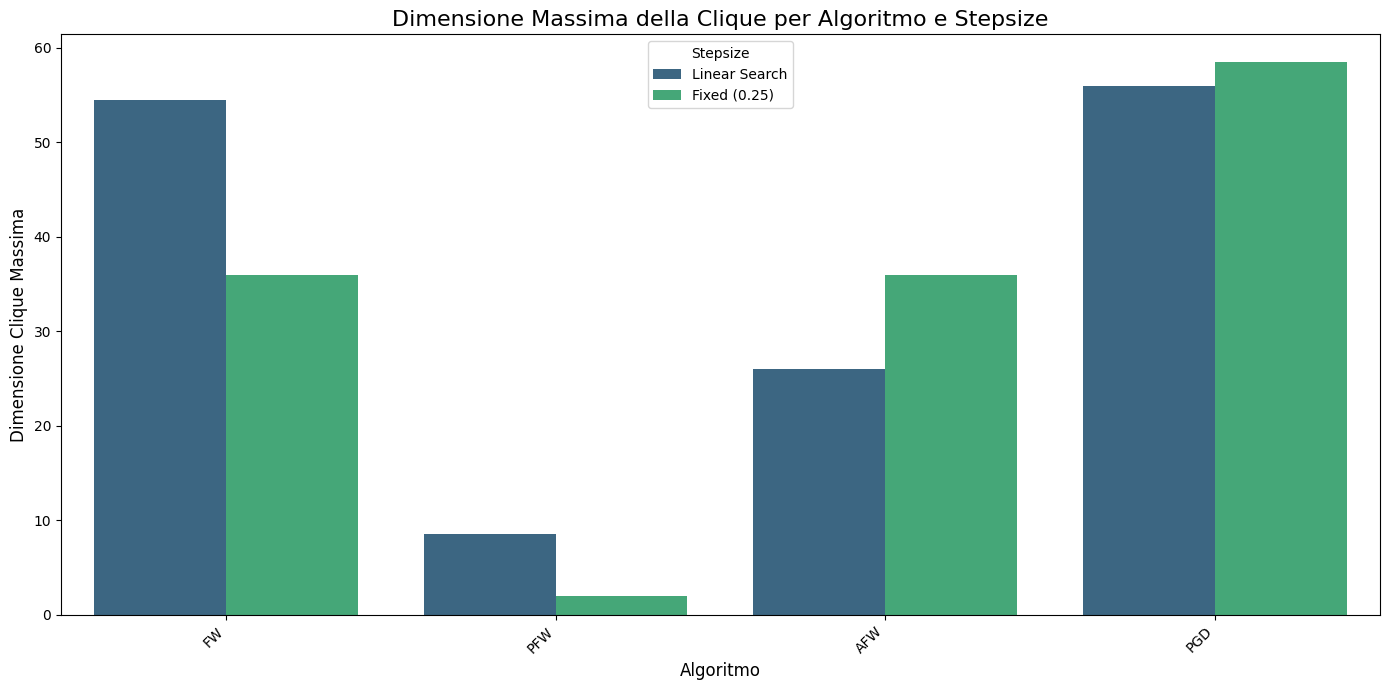

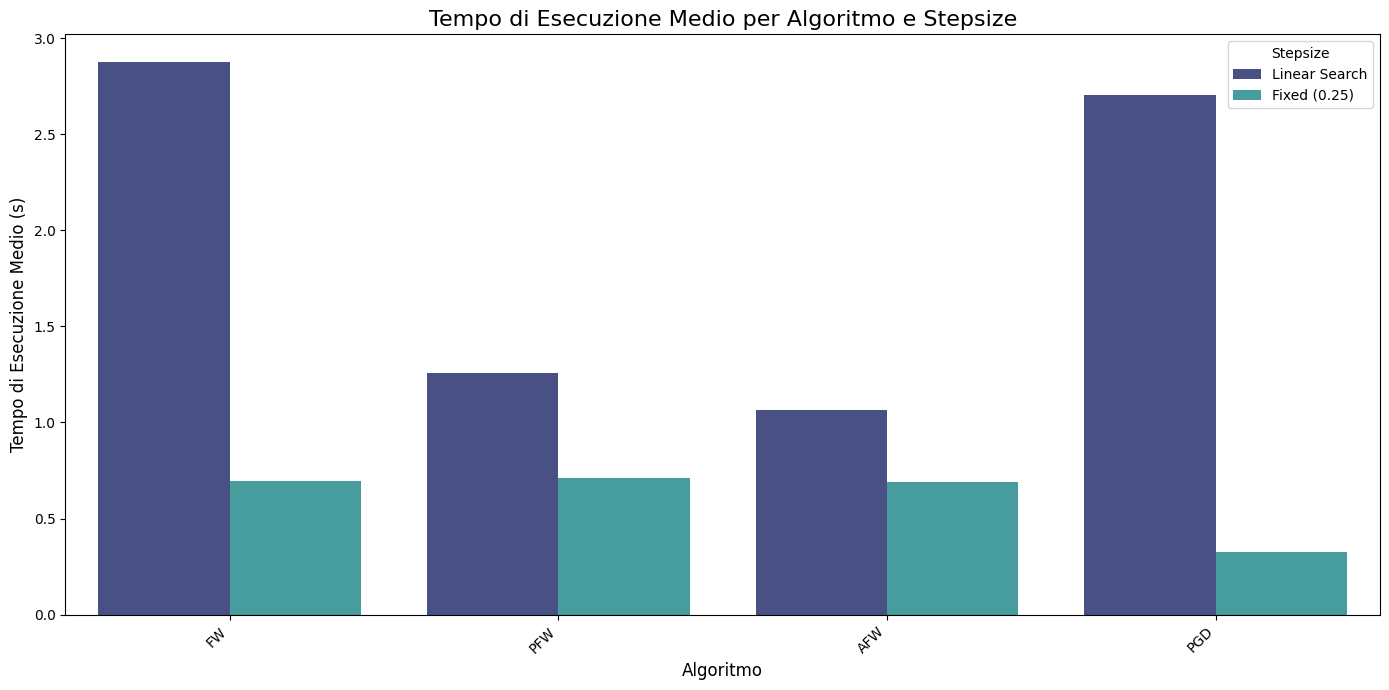

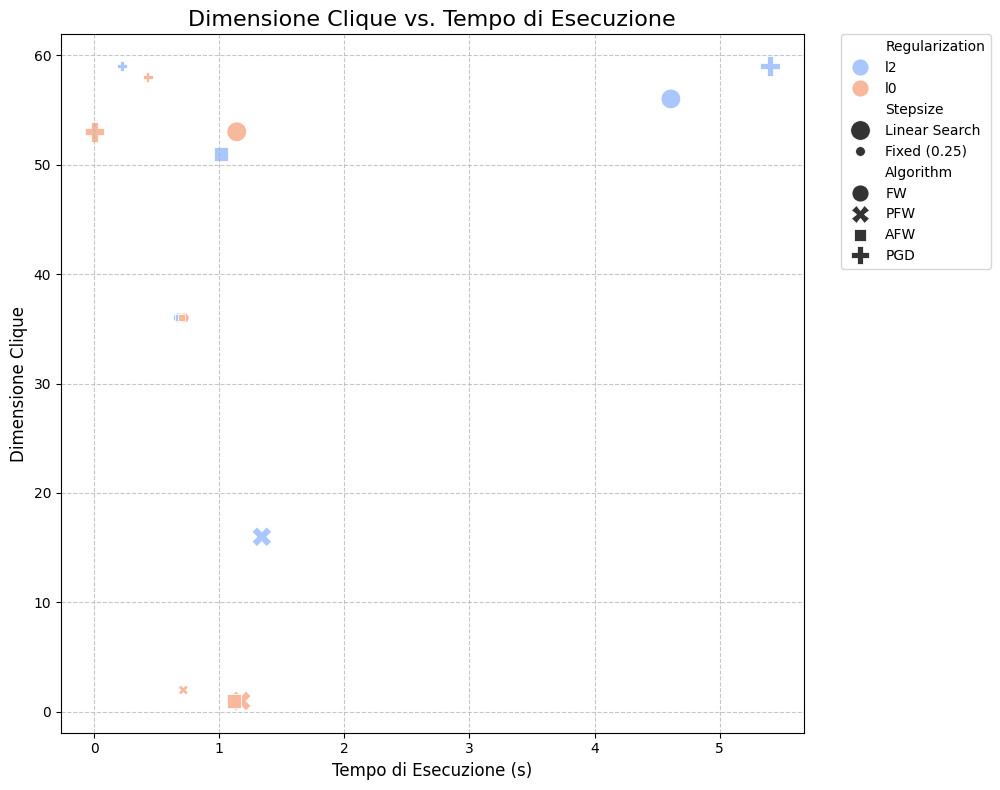

<Figure size 1500x800 with 0 Axes>

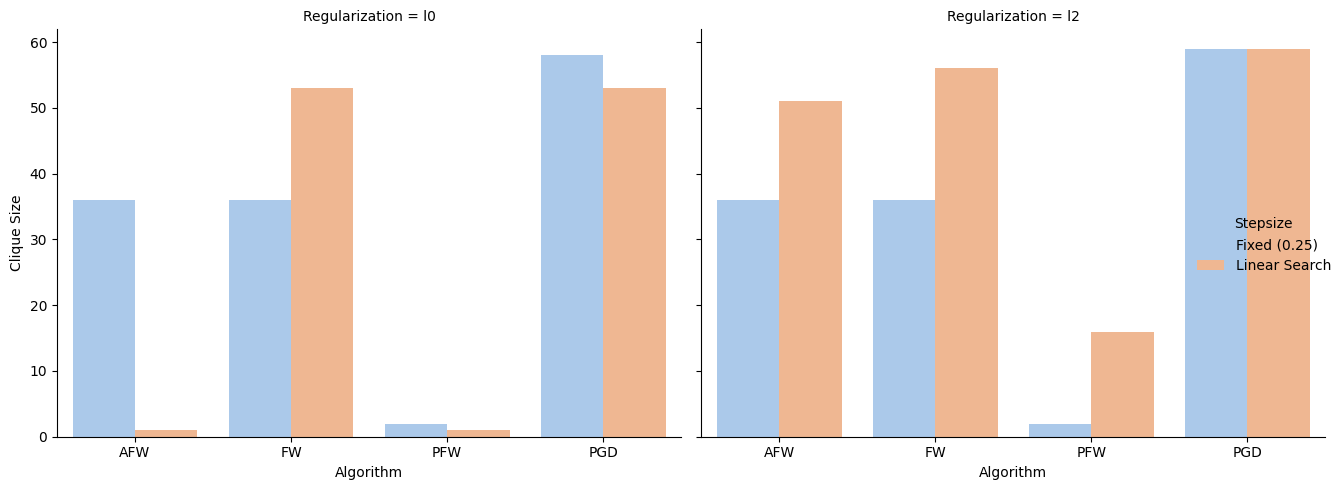

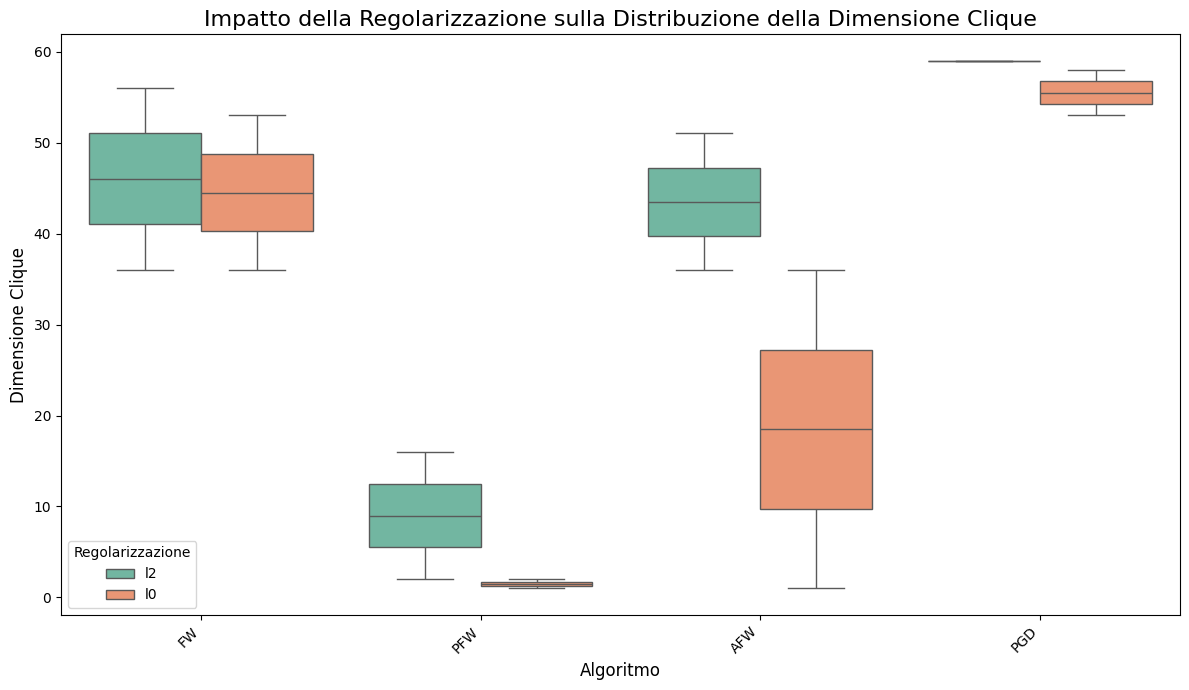

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
df_valid_results = df_results[(df_results['Valid Clique'] == True) & (df_results['Clique Size'] > 0)]

if 'Error' in df_valid_results.columns:
    df_valid_results = df_valid_results[df_valid_results['Error'].isnull()]

if df_valid_results.empty:
    print("Attenzione: Nessun risultato valido trovato dopo il filtraggio. I grafici potrebbero essere vuoti o non generati.")
else:
    print(f"Numero di risultati validi per i grafici: {len(df_valid_results)}")

    # --- 1. Dimensione Massima della Clique per Algoritmo e Stepsize ---
    plt.figure(figsize=(14, 7))
    sns.barplot(data=df_valid_results, x='Algorithm', y='Clique Size', hue='Stepsize', palette='viridis', errorbar=None)
    plt.title('Dimensione Massima della Clique per Algoritmo e Stepsize', fontsize=16)
    plt.xlabel('Algoritmo', fontsize=12)
    plt.ylabel('Dimensione Clique Massima', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Stepsize')
    plt.tight_layout()
    plt.show()

    # --- 2. Tempo di Esecuzione Medio per Algoritmo e Stepsize ---
    plt.figure(figsize=(14, 7))
    sns.barplot(data=df_valid_results, x='Algorithm', y='Runtime (s)', hue='Stepsize', palette='mako', errorbar=None)
    plt.title('Tempo di Esecuzione Medio per Algoritmo e Stepsize', fontsize=16)
    plt.xlabel('Algoritmo', fontsize=12)
    plt.ylabel('Tempo di Esecuzione Medio (s)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Stepsize')
    plt.tight_layout()
    plt.show()

    # --- 3. Dimensione Clique vs. Tempo di Esecuzione (Scatter Plot) ---
    # Differenzia per algoritmo (shape) e regolarizzazione (colore)
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=df_valid_results, x='Runtime (s)', y='Clique Size',
                    hue='Regularization', style='Algorithm', size='Stepsize', # 'size' per differenziare stepsize
                    sizes=(50, 200), palette='coolwarm', s=150) # s è la dimensione di default per i punti
    plt.title('Dimensione Clique vs. Tempo di Esecuzione', fontsize=16)
    plt.xlabel('Tempo di Esecuzione (s)', fontsize=12)
    plt.ylabel('Dimensione Clique', fontsize=12)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout(rect=[0, 0, 0.85, 1]) # Aggiusta il layout per far spazio alla legenda
    plt.show()

    # --- 4. Impatto della Stepsize sulla Dimensione della Clique (Grouped Bar) ---
    # Media della dimensione clique per Algoritmo, Regolarizzazione, Stepsize
    # Potrebbe essere più utile vedere la *massima* clique size, a seconda dell'obiettivo.
    # Qui uso la media per generalizzare, ma potresti voler cambiare .mean() con .max()
    grouped_clique = df_valid_results.groupby(['Algorithm', 'Regularization', 'Stepsize'])['Clique Size'].mean().reset_index()
    
    if not grouped_clique.empty:
        plt.figure(figsize=(15, 8))
        sns.catplot(data=grouped_clique, x='Algorithm', y='Clique Size', hue='Stepsize',
                    col='Regularization', kind='bar', palette='pastel', height=5, aspect=1.2)
        # plt.suptitle('Impatto della Stepsize sulla Dimensione Media della Clique', y=1.03, fontsize=16) # suptitle per catplot
        # I titoli dei singoli subplots sono gestiti da catplot con col_wrap
        # Se non usi col_wrap, potresti dover aggiustare il titolo principale.
        # Per catplot, i titoli dei subplot sono generati automaticamente.
        # Per personalizzare i titoli dei subplot individuali:
        # g = sns.catplot(...)
        # g.set_titles("{col_name}")
        # g.set_xlabels("Algoritmo")
        # g.set_ylabels("Dimensione Media Clique")
        plt.tight_layout()
        plt.show()
    else:
        print("Dati non sufficienti per il grafico 'Impatto della Stepsize sulla Dimensione della Clique'.")


    # --- 5. Impatto della Regolarizzazione sulla Dimensione della Clique (Box Plot) ---
    # Mostra la distribuzione delle dimensioni delle clique per tipo di regolarizzazione
    plt.figure(figsize=(12, 7))
    sns.boxplot(data=df_valid_results, x='Algorithm', y='Clique Size', hue='Regularization', palette='Set2')
    plt.title('Impatto della Regolarizzazione sulla Distribuzione della Dimensione Clique', fontsize=16)
    plt.xlabel('Algoritmo', fontsize=12)
    plt.ylabel('Dimensione Clique', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Regolarizzazione')
    plt.tight_layout()
    plt.show()